In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

In [ ]:
df = pd.read_csv("../Datasets/Cuvinte-Eliminate/train-punct-stop-1000.csv")
df=df.dropna()
df=df.sample(n=100000)
#df=df.drop(["news_title","url","reddit_title"],axis=1)
df_train=df


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2022-03-02 10:24:19.216358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 10:24:19.227561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 10:24:19.228008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
df = pd.read_csv("../Datasets/Stem-Cuvinte-Eliminate/train-punct-stop-stem-200.csv")
df=df.dropna()
df_poz=df[df['sentiment'] == 2]
df_neg=df[df['sentiment'] == 0]
df_poz=df_poz.sample(500000)
df_neg=df_neg.sample(500000)
df = pd.concat([df_poz,df_neg])
#df=df.drop(["news_title","url","reddit_title"],axis=1)
df_train=df

In [3]:
X_train = df_train['text']

max phrase len: 153


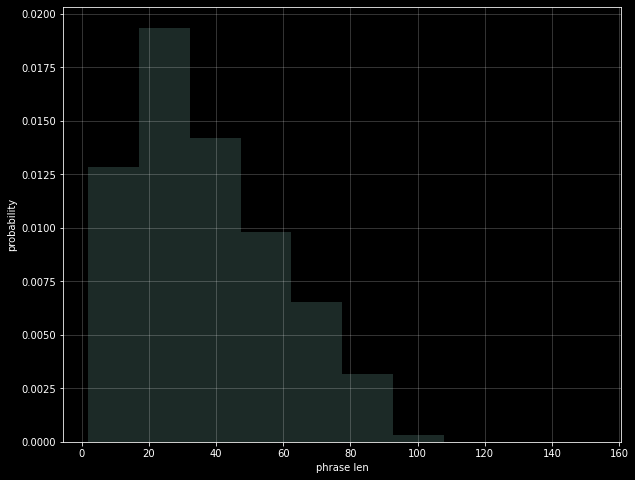

In [4]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [5]:
y_train = df_train['sentiment'].values

In [6]:
train_labels=[]
for i in range(0,len(y_train)):
    train_labels.append([0,0])

In [7]:
len(y_train)

1000000

In [8]:
train_labels=np.array(train_labels)

In [9]:
y_train

array([2, 2, 2, ..., 0, 0, 0])

In [10]:
for i in range(0,len(y_train)):
    if y_train[i] == 0:
        train_labels[i][0]=1
    else:
        train_labels[i][1]=1

In [11]:
train_labels

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
#max_words = 16384
max_words = 32768
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = 128)

In [13]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = 128)

In [14]:
print(X_train[0])
print(train_labels[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   80   25   10   24   73
   50  527  223  248 1175 2489  279  812 1167  131   80  645   12    4
  947 3277  318  121 1204 3277   10   51 3277   69 2525   84  200 1747
 1633  111  128  925 1027 1633   71 2461    6  442  494  216 1116   25
  107   21]
[0 1]


In [17]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = 32768, output_dim = 256, input_length = 128))
model_lstm.add(SpatialDropout1D(0.30))
model_lstm.add(LSTM(128, dropout = 0.30, recurrent_dropout = 0.30,return_sequences=True))
model_lstm.add(Dropout(0.30))
model_lstm.add(LSTM(128, dropout = 0.30, recurrent_dropout = 0.30,return_sequences=True))
model_lstm.add(Dropout(0.30))
model_lstm.add(LSTM(128, dropout = 0.30, recurrent_dropout = 0.30))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.30))
model_lstm.add(Dense(2, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [18]:
history = model_lstm.fit(
    X_train,
    train_labels,
    validation_split = 0.1,
    epochs = 3,
    batch_size = 256
)

Epoch 1/3
3516/3516 [==============================] - 5069s 1s/step - loss: 0.2878 - accuracy: 0.8794 - val_loss: 0.2488 - val_accuracy: 0.9111
Epoch 2/3
3516/3516 [==============================] - 4848s 1s/step - loss: 0.2346 - accuracy: 0.9051 - val_loss: 0.3055 - val_accuracy: 0.8803
Epoch 3/3
3516/3516 [==============================] - 4910s 1s/step - loss: 0.2132 - accuracy: 0.9145 - val_loss: 0.3071 - val_accuracy: 0.8845


In [ ]:
plt.plot(history.history['loss'], label='train loss'),
plt.plot(history.history['val_loss'], label='val loss'),
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss"),

In [ ]:
    plt.plot(history.history['accuracy'], label='train accuracy'),
    plt.plot(history.history['val_accuracy'], label='val accuracy'),
    plt.xlabel("epoch"),
    plt.ylabel("accuracy"),
    plt.legend();

In [ ]:
model_lstm.save('./Model-200-l3/')

In [ ]:
import pickle
with open('tokenizer-200-nou-t.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
import pickle
with open('tokenizer-200-nou.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)